<a href="https://colab.research.google.com/github/jacheung/still-learning/blob/master/autocurator_CNN_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# import necessary libraries
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# Load datasets 
raw_X = np.load('/content/gdrive/My Drive/Colab Notebooks/AH0000x000000-1_dataset.npy')
raw_Y = np.rot90(np.load('/content/gdrive/My Drive/Colab Notebooks/AH0000x000000-1_touchClass.mat.npy'))


# 2) Basic EDA  
We're going to verify that the data looks good by eye. 



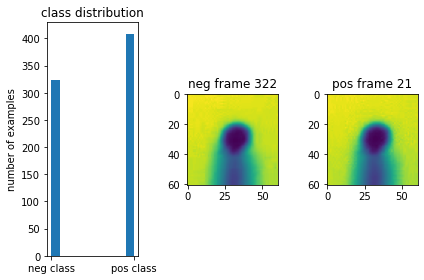

In [6]:
# Look at the distribution of classes
fig, axs = plt.subplots(1, 3)
axs[0].hist(raw_Y)
axs[0].set_title('class distribution')
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['neg class', 'pos class'])
axs[0].set_ylabel('number of examples')

# Look at some images of positive and negative
neg_class = [i for i, val in enumerate(raw_Y) if val==0]
pos_class = [i for i, val in enumerate(raw_Y) if val==1]
axs[1].imshow(raw_X[np.random.choice(neg_class,1)[0]])
axs[1].set_title('neg frame ' + str(np.random.choice(neg_class,1)[0]))
axs[2].imshow(raw_X[np.random.choice(pos_class,1)[0]])
axs[2].set_title('pos frame ' + str(np.random.choice(pos_class,1)[0]))
plt.tight_layout()

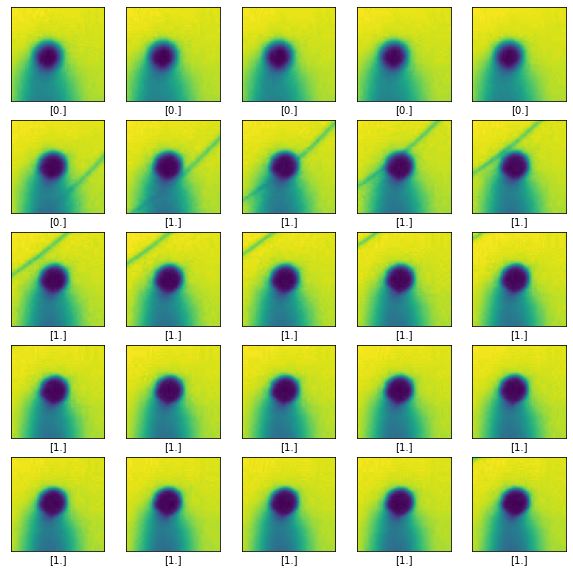

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(raw_X[i])
    plt.xlabel(str(raw_Y[i]))
plt.show()

# 3) Data cleaning  
In this section we're going to convert the images to the right dimensions for MobileNetV2. I believe we have to transform them all to 160x160 px images. Input images for pole and touches are 61x61 px. 

In [8]:
# convert grayscale image (1 channel) to rgb image (3 channel) for pretrained networks
print('raw image size = ' + str(raw_X.shape))  # (64, 224, 224)
rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
print('converted rgb image size = ' + str(rgb_batch.shape))

raw image size = (732, 61, 61)
converted rgb image size = (732, 61, 61, 3)


In [24]:
IMG_SIZE = 160 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes
mean_img_density = np.mean([x.mean() for x in raw_X]) # All images will be mean normalized to average value

rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor
rgb_tensor = rgb_tensor / mean_img_density # mean normalization 
rgb_tensor = tf.image.resize(rgb_tensor, (160, 160)) # resizing

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 4) Model compilation and set up
In this section we're going to use MobileNetV2 as the base model.
We're going to run two variations of the model.  
a. basemodel with frozen layers and output classifer changes   
b. basemodel with final 100 layers unfrozen to optimize prediction 


In [27]:
# Create base model 

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model(rgb_tensor)
print(feature_batch.shape)

# Adding Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Model Stacking
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

print(model)


(732, 5, 5, 1280)
(732, 1280)
(732, 1)


In [28]:
# Compile model 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Train the model 
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

In [ ]:
# Model evaluation 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Fine-tuning model by unfreezing layers and allowing them to be trainable

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False